In [1]:
import pandas as pd
import os
import seaborn as sns
sns.set(style='ticks', context='paper')
import numpy as np
from util import plot_cdf
from scipy.ndimage import gaussian_filter1d

In [2]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [3]:
worst_low_id=1
mlsys_dir="mlsys"
mix_dir = f'../data_ori/{worst_low_id}'
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99, " error: ",error)
print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}")

sldn_ns3:  2.8153335339189587  sldn_pmn_m:  3.059336076470931  error:  0.08666914225694584
df_ns3: 11351430, df_pmn_m: 11351644


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


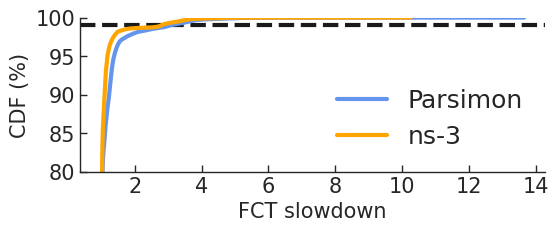

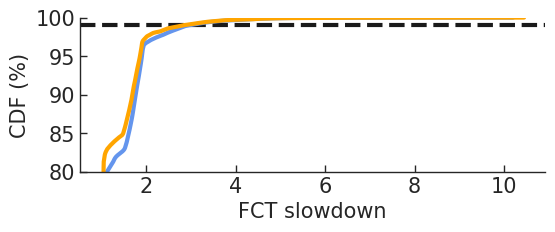

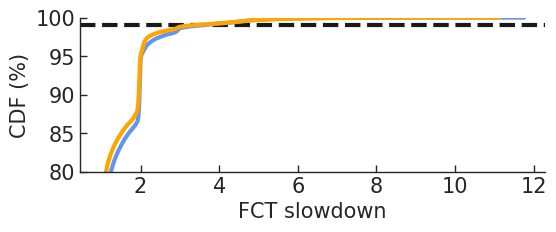

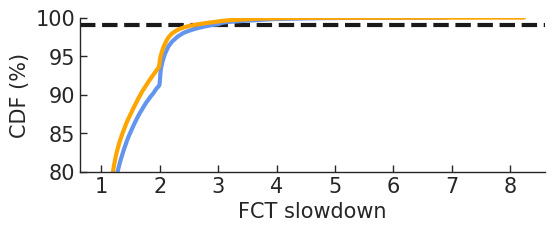

In [4]:
bin_size_list=[10*MTU, 10*BDP, 100 * BDP]
legend_list=['Parsimon','ns-3',]
bin_ns3=np.digitize(df_ns3['size'], bin_size_list)
bin_pmn_m=np.digitize(df_pmn_m['size'], bin_size_list)
for i in range(len(labels)):
    
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    
    plot_data=[tmp_sldn_pmn_m,tmp_sldn_ns3]
    plot_cdf(plot_data,f'figs/eva_large_scale_{i}.pdf',legend_list if i==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=80,log_switch=False)
    

In [5]:
bin_size_list=[MTU, BDP, 5 * BDP]
np.random.seed(1)
N_FLOWS=500*100*4
N_FLOW_THRESHOLD = [1, 1, 1, 1]
worst_low_id=0
mlsys_dir="mlsys"
mix_dir = f'../data/{worst_low_id}'
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3-config/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_mlsys = [[] for _ in range(n_size_bucket_list_output)]

n_freq_list=[]
n_flow_list=[]
sizes=df_pmn_m['size']

path_idx=0
while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
    with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
        lines = file.readlines()
        data=lines[0].strip().split(",")
        n_freq_list.append(int(data[-1]))
        
        flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
        size_list=[sizes[flowid] for flowid in flowid_list]
        
        n_links=len(data[0].split("|"))-1
        tmp=np.digitize(size_list, bin_size_list)
        # Count occurrences of each bin index
        bin_counts = np.zeros(n_size_bucket_list_output)
        for bin_idx in tmp:
            bin_counts[bin_idx]+=1
        n_flow_list.append(bin_counts)
    path_idx+=1
n_flow_list=np.array(n_flow_list)
n_flow_list_sum=n_flow_list.sum(axis=0)

with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
    lines = file.readlines()
    lines=lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD[line_idx%n_size_bucket_list_output]:
            for _ in range(n_freq):
                df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]

sizes_ns3=df_ns3['size']
bin_ns3=np.digitize(sizes_ns3, bin_size_list)

bin_counts = np.bincount(bin_ns3)
total_count = np.sum(bin_counts)
# # Calculate the ratio for each bucket
bucket_ratios = bin_counts / total_count
print("bucket_ratios: ",bucket_ratios)
bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
print("bucket_ratios_sampled: ",bucket_ratios_sampled)
            
df_mlsys_bucket=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
print("df_mlsys_bucket: ",df_mlsys_bucket)
df_mlsys_total=[]
for i in range(len(df_mlsys)):
    # df_mlsys_total.extend(df_mlsys[i])
    n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
    
    # sorted_list = np.sort(df_mlsys[i])
    # percentile_index = np.array([int((i * 1 / n_tmp) * (len(sorted_list) - 1)) for i in range(1,n_tmp+1)])
    # df_mlsys_total.extend(sorted_list[percentile_index])
    
    df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
df_mlsys_p99=np.percentile(df_mlsys_total,99)

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," df_mlsys: ", df_mlsys_p99)
error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
error_mlsys=(df_mlsys_p99-sldn_ns3_p99)/sldn_ns3_p99

print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys_shape}")

res_total=[np.array(df_mlsys_total), sldn_pmn_m, sldn_ns3]

bucket_ratios:  [0.3577588  0.44385298 0.08892915 0.10945907]
bucket_ratios_sampled:  [0.34416826 0.45315488 0.10133843 0.10133843]
df_mlsys_bucket:  [1.590548   1.39235038 2.353723   3.100757  ]
sldn_ns3:  2.045282183084257  sldn_pmn_m:  4.29052707882781  df_mlsys:  2.0967994800000165
df_ns3: 11351430, df_pmn_m: 11351644, df_mlsys: [17700, 23400, 5200, 5300]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


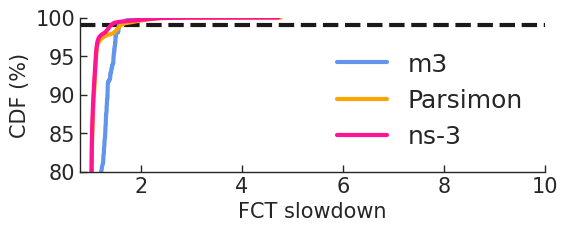

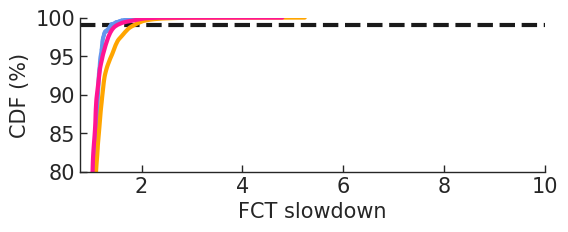

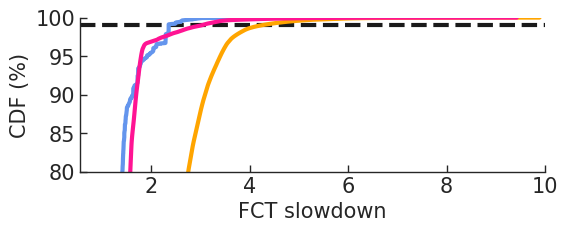

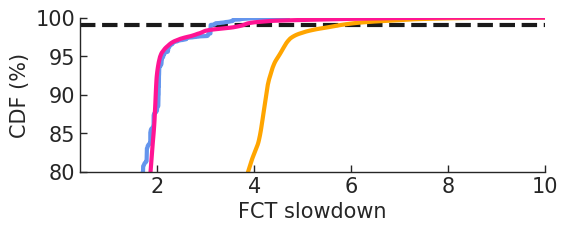

In [6]:
legend_list=['m3','Parsimon','ns-3']
bin_ns3=np.digitize(df_ns3['size'], bin_size_list)
bin_pmn_m=np.digitize(df_pmn_m['size'], bin_size_list)
x_lim_list=[10,10,10,10]
for i in range(len(labels)):
    
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    tmp_sldn_mlsys=np.array(df_mlsys[i])
    
    plot_data=[tmp_sldn_mlsys,tmp_sldn_pmn_m,tmp_sldn_ns3]
    plot_cdf(plot_data,f'figs/eva_large_scale_{i}.pdf',legend_list if i==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=80,log_switch=False,xlim=x_lim_list[i])
    